# Calibration of best-estimate in-default LGD model

EBA/GL/2017/16: 
####1. For risk parameters for defaulted exposures, all requirements specified for LGD in Chapter 6 apply, unless explicitly specified otherwise. A major aspect which differentiates ELBE and LGD indefault from LGD for non-defaulted exposures is the concept of reference dates, which have to be
taken into account both in model development and in calibration, given that the calibration has to be performed separately for each reference date.
####2. 161. Institutions should calibrate their LGD estimates to the long run average LGD calculated in accordance with section 6.3.2.
####3. 178. For the purposes of ELBE and LGD in-default estimation, institutions should calculate the realised LGDs for defaulted exposures, in accordance with section 6.3.1 with the only difference that this should be done with regard to each of the reference dates specified in accordance with paragraphs 171 to 174, rather than the date of default. In the calculation of the realised LGD at a given reference date institutions should include all fees and interest
capitalised before the reference date and they should discount all subsequent cash flows and drawings to the reference date.
####4. 150. Without prejudice to Article 181(2) of Regulation (EU) No 575/2013 institutions should calculate the long-run average LGD as an arithmetic average of realised LGDs over a historical observation period weighted by a number of defaults. Institutions should not use for that purpose any averages of LGDs calculated on a subset of observations, in particular any yearly average LGDs, unless they use this method to reflect higher weights of more recent data on
retail exposures in accordance with Article 181(2) of Regulation (EU) No 575/2013.

In [ ]:
import numpy as np
import pandas as pd
import random

from statsmodels.genmod import families
links = families.links
from statsmodels.othermod.betareg import BetaModel

In [ ]:
# Parametrisation
num_contracts = 10
max_reference_periods = 10
contract_reference_periods = range(2, max_reference_periods)
length_of_outlier_contract = 1 # test with 1000 to see the outlier's influence
lgd_of_outlier_contract = 0.9 

In [ ]:
# Create synthetic dataset
data = []

for contract_id in range(1, num_contracts):
  periods = random.choice(contract_reference_periods)
  if contract_id == 1:
    periods = length_of_outlier_contract

  for period in range(1, periods):
    mob = period
    repaid_percent = np.where(mob > 3, 0.5, 0.1) + random.random()
    realised_lgd = (random.random() * (period/max_reference_periods) + 
                    repaid_percent * random.random() / 3)

    if contract_id == 1:
      realised_lgd = lgd_of_outlier_contract

    # Store dataset
    data.append([contract_id, period, mob, repaid_percent, realised_lgd])

# Create dataframe and standardise lgd
def normalise(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

cols = ['contract_id', 'period', 'mob', 'repaid_percent', 'realised_lgd']
df = pd.DataFrame(data, columns=cols)
df['realised_lgd'] = normalise(df['realised_lgd'])
df['realised_lgd'] = np.clip(df['realised_lgd'], 0.0001, 0.9999)

In [ ]:
# Create beta regression
model = "I(realised_lgd) ~ repaid_percent + mob"
beta_lgd = BetaModel.from_formula(model, df, link_precision=links.identity())
res = beta_lgd.fit()
print(res.summary())

df['predict_lgd'] = res.predict()

                              BetaModel Results                               
Dep. Variable:        I(realised_lgd)   Log-Likelihood:                 11.792
Model:                      BetaModel   AIC:                            -15.58
Method:            Maximum Likelihood   BIC:                            -8.183
Date:                Sat, 19 Nov 2022                                         
Time:                        21:00:49                                         
No. Observations:                  47                                         
Df Residuals:                      43                                         
Df Model:                           3                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -1.7308      0.437     -3.958      0.000      -2.588      -0.874
repaid_percent     0.7233      0.577    

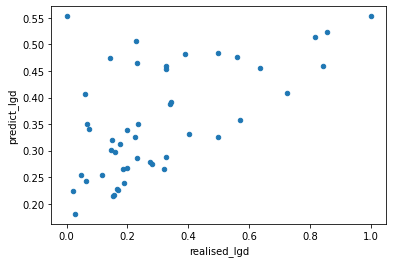

In [ ]:
df.plot.scatter(x='realised_lgd', y='predict_lgd');

In [ ]:
# Create pools (todo: use regression)
df['pool'] = pd.cut(df['predict_lgd'], 3, labels=["1", "2", "3"])
df.head()

,contract_id,period,mob,repaid_percent,realised_lgd,predict_lgd,pool
0,2,1,1,0.515681,0.167844,0.225692,1
1,2,2,2,0.639344,0.185177,0.265352,1
2,2,3,3,0.952215,0.197611,0.339167,2
3,3,1,1,0.535469,0.165157,0.228204,1
4,3,2,2,0.801142,0.327129,0.288784,1


In [ ]:
# Calculate Long Run Average LGD per pool
df.groupby(['pool'])['realised_lgd'].mean()

pool
1    0.170150
2    0.290317
3    0.489257
Name: realised_lgd, dtype: float64